In [9]:
from graph_tool.all import *
import graph_tool.all as gt
import matplotlib.pyplot as plt
import numpy as np
import random

rng = np.random.default_rng()

In [10]:
#Build and initiate networks

rng = np.random.default_rng() #create a random number generator

def build_net(N):
    G = Graph(directed=True)
    
    for i in range(0, N):
        #step 1(a)
        if i == 0:
            G.add_vertex()
            
        else:
            #step 1(b)
            G.add_vertex()
            poss_adjs = tuple(np.arange(0, i, 1))
            chosen_node_b = str(random.choice(poss_adjs))
            G.add_edge(G.vertex(chosen_node_b), G.vertex(i))
        
            #step 1(c)
            chosen_node_c = str(random.choice(poss_adjs))
            G.add_edge(G.vertex(i), G.vertex(chosen_node_c))
    
    return G

def net_init(GA, GB, NA, NB, dA, dB):
    G1 = Graph(GA)
    G2 = Graph(GB)
    
    vertex_state1 = G1.new_vertex_property("int16_t")
    vertex_state2 = G2.new_vertex_property("int16_t")
    
    indexes = rng.choice(NA, size = int(round(dA*NA/100)), replace=False)
    
    for index in indexes:
        vertex_state1[G1.vertex(index)] = 1
    
    indexes = rng.choice(NB, size = int(round(dB*NB/100)), replace=False)
    
    for index in indexes:
        vertex_state2[G2.vertex(index)] = 1    
        
    return G1, vertex_state1, G2, vertex_state2

In [12]:
#Vitality calculation

def vitality(G, N, vertex_state):
    phi = N
    for vertex in G.get_vertices():
        if vertex_state[vertex] == True:
            phi += -1
    return phi/N

In [13]:
#Co-aging function

def coaging(G1, vertex_state1, G2, vertex_state2, N_1, N_2, C_1, gamma_s1_0, gamma_1_1, C_2, gamma_s2_0, gamma_2_1):
    phi_1 = vitality(G1, N_1, vertex_state1)
    phi_2 = vitality(G2, N_2, vertex_state2)
    phis_1 = [phi_1]
    phis_2 = [phi_2]
    
    history_1 = []
    history_2 = []
    
    while phi_1>0.1 or phi_2>0.1:
        #gamma_c1_0 = C_1*phi_2
        #gamma_c2_0 = C_2*phi_1
        
        for vertex in G1.get_vertices():
            if vertex_state1[vertex] == 0:
                if (np.random.random() < gamma_s1_0) == True:
                    vertex_state1[vertex] = 1
                    if (np.random.random() < gamma_1_1) == True:
                        vertex_state1[vertex] = 0

        for vertex in G2.get_vertices():
            if vertex_state2[vertex] == 0:
                if (np.random.random() < gamma_s2_0) == True:
                    vertex_state2[vertex] = 1
                    if (np.random.random() < gamma_2_1) == True:
                        vertex_state2[vertex] = 0

        while True:
            broken_nodes = False
            for vertex in G1.get_vertices():
                if vertex_state1[vertex] == 0:
                    liv_pred_1 = 0
                    neigh_1 = 0
                    natural_dead = 0
                    damage_dead = 0
                    
                    for pred in G1.get_in_neighbors(vertex):
                        neigh_1 += 1
                        if vertex_state1[pred] == 0:
                            liv_pred_1 += 1
                        elif vertex_state1[pred] == 1:
                            natural_dead += 1
                        elif vertex_state1[pred] == 2:
                            damage_dead += 1
                            
                    if liv_pred_1/neigh_1 < 0.5:
                        vertex_state1[vertex] = 1
                        broken_nodes = True                         
            if broken_nodes == False:
                break
    
        while True:
            broken_nodes = False
            for vertex in G2.get_vertices():
                if vertex_state2[vertex] == 0:
                    liv_pred_2 = 0
                    neigh_2 = 0
                    natural_dead = 0
                    damage_dead = 0
                    
                    for pred in G2.get_in_neighbors(vertex):
                        neigh_2 += 1
                        if vertex_state2[pred] == 0:
                            liv_pred_2 += 1
                        elif vertex_state2[pred] == 1:
                            natural_dead += 1
                        elif vertex_state2[pred] == 2:
                            damage_dead += 1
                            
                    if liv_pred_2/neigh_2 < 0.5:
                        vertex_state2[vertex] = 1
                        broken_nodes = True
            if broken_nodes == False:
                break

        ratio_0_1 = 0
        ratio_1_1 = 0
        ratio_2_1 = 0
        
        for vertex in G1.get_vertices():
            if vertex_state1[vertex] == 0:
                ratio_0_1 += 1
            if vertex_state1[vertex] == 1:
                ratio_1_1 += 1
            if vertex_state1[vertex] == 2:
                ratio_2_1 += 1 
                
        ratio_0_1 = ratio_0_1/N_1
        ratio_1_1 = ratio_1_1/N_1
        ratio_2_1 = ratio_2_1/N_1
        
        #if ratio_0_1 > 0.1:
        #    history_1.append([round(ratio_1_1,3), round(ratio_2_1,3)])
        
        #phi_1 = ratio_0_1
        
        #if phi_1 > 0.1:
        #    phis_1.append(phi_1)
        #else:
        #    phi_1 = 0
                
        ratio_0_2 = 0
        ratio_1_2 = 0
        ratio_2_2 = 0
        
        for vertex in G2.get_vertices():
            if vertex_state2[vertex] == 0:
                ratio_0_2 += 1
            if vertex_state2[vertex] == 1:
                ratio_1_2 += 1
            if vertex_state2[vertex] == 2:
                ratio_2_2 += 1  
                
        ratio_0_2 = ratio_0_2/N_2
        ratio_1_2 = ratio_1_2/N_2
        ratio_2_2 = ratio_2_2/N_2
        
        #if ratio_0_2 > 0.1:
        #    history_2.append([round(ratio_1_2,3), round(ratio_2_2,3)])        
        
        #phi_2 = ratio_0_2
        
        #if phi_2 > 0.1:
        #    phis_2.append(phi_2)
        #else:
        #    phi_2 = 0
        
        #if phi_1 < 0.1 and phi_2 < 0.1:
        
        if ratio_0_1 < 0.1 and ratio_0_2 < 0.1:
            phis_1.append(0)
            phis_2.append(0)
            history_1.append([round(ratio_1_1,3), round(ratio_2_1,3)])
            history_2.append([round(ratio_1_2,3), round(ratio_2_2,3)])
            break

#######Coaging Part########

        gamma_c1_0 = C_1*phi_2
        gamma_c2_0 = C_2*phi_1
        
        for vertex in G1.get_vertices():
            if vertex_state1[vertex] == 0:
                if (np.random.random() < gamma_c1_0) == True:
                    vertex_state1[vertex] = 2
                    if (np.random.random() < gamma_1_1) == True:
                        vertex_state1[vertex] = 0
                        
        for vertex in G2.get_vertices():
            if vertex_state2[vertex] == 0:
                if (np.random.random() < gamma_c2_0) == True:
                    vertex_state2[vertex] = 2
                    if (np.random.random() < gamma_2_1) == True:
                        vertex_state2[vertex] = 0
                        
        
        #Loop of first network            
        while True:
            broken_nodes = False
            for vertex in G1.get_vertices():
                if vertex_state1[vertex] == 0:
                    liv_pred_1 = 0
                    neigh_1 = 0
                    natural_dead = 0
                    damage_dead = 0
                    
                    for pred in G1.get_in_neighbors(vertex):
                        neigh_1 += 1
                        if vertex_state1[pred] == 0:
                            liv_pred_1 += 1
                        elif vertex_state1[pred] == 1:
                            natural_dead += 1
                        elif vertex_state1[pred] == 2:
                            damage_dead += 1
                            
                    if liv_pred_1/neigh_1 < 0.5:
                        vertex_state1[vertex] = 2
                        broken_nodes = True                         
            if broken_nodes == False:
                break
                
        ratio_0_1 = 0
        ratio_1_1 = 0
        ratio_2_1 = 0
        
        for vertex in G1.get_vertices():
            if vertex_state1[vertex] == 0:
                ratio_0_1 += 1
            if vertex_state1[vertex] == 1:
                ratio_1_1 += 1
            if vertex_state1[vertex] == 2:
                ratio_2_1 += 1 
                
        ratio_0_1 = ratio_0_1/N_1
        ratio_1_1 = ratio_1_1/N_1
        ratio_2_1 = ratio_2_1/N_1
        
        if ratio_0_1 > 0.1:
            history_1.append([round(ratio_1_1,3), round(ratio_2_1,3)])
            
        phi_1 = ratio_0_1
        
        if phi_1 > 0.1:
            phis_1.append(phi_1)
        else:
            phi_1 = 0 
            
                            
        #Loop of second network
        while True:
            broken_nodes = False
            for vertex in G2.get_vertices():
                if vertex_state2[vertex] == 0:
                    liv_pred_2 = 0
                    neigh_2 = 0
                    natural_dead = 0
                    damage_dead = 0
                    
                    for pred in G2.get_in_neighbors(vertex):
                        neigh_2 += 1
                        if vertex_state2[pred] == 0:
                            liv_pred_2 += 1
                        elif vertex_state2[pred] == 1:
                            natural_dead += 1
                        elif vertex_state2[pred] == 2:
                            damage_dead += 1
                            
                    if liv_pred_2/neigh_2 < 0.5:
                        vertex_state2[vertex] = 2
                        broken_nodes = True
            if broken_nodes == False:
                break
            
        ratio_0_2 = 0
        ratio_1_2 = 0
        ratio_2_2 = 0
        
        for vertex in G2.get_vertices():
            if vertex_state2[vertex] == 0:
                ratio_0_2 += 1
            if vertex_state2[vertex] == 1:
                ratio_1_2 += 1
            if vertex_state2[vertex] == 2:
                ratio_2_2 += 1  
                
        ratio_0_2 = ratio_0_2/N_2
        ratio_1_2 = ratio_1_2/N_2
        ratio_2_2 = ratio_2_2/N_2
        
        if ratio_0_2 > 0.1:
            history_2.append([round(ratio_1_2,3), round(ratio_2_2,3)])  
        
        phi_2 = ratio_0_2
        
        if phi_2 > 0.1:
            phis_2.append(phi_2)
        else:
            phi_2 = 0
    
        
        if phi_1 < 0.1 and phi_2 < 0.1:
            phis_1.append(0)
            phis_2.append(0)
            history_1.append([round(ratio_1_1,3), round(ratio_2_1,3)])
            history_2.append([round(ratio_1_2,3), round(ratio_2_2,3)])

    return phis_1, phis_2, history_1[-1], history_2[-1]

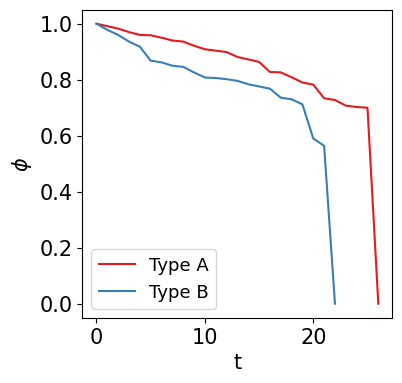

In [27]:
#Co-age networks and plot vitality

N1 = 800
runs_phi_1 = []
living_times_1 = []
aging_hist_1 = []

N2 = 500
runs_phi_2 = []
living_times_2 = []
aging_hist_2=[]

# probabilities for networks
gamma_s1_0 = 0.005
gamma_1_1 = 0.0
C_1 = 0.001
d_1 = 0.0

gamma_s2_0 = 0.01
gamma_2_1 = 0.0
C_2 = 0.001
d_2 = 0.0

G_A = build_net(N1)
#G_A.save("network_a.gt.gz")
G_B = build_net(N2) 
#G_B.save("network_b.gt.gz")

#G_A = load_graph("network_a.gt.gz")

#G_B = load_graph("network_b.gt.gz")

net_couple_num = 1

for net in range(net_couple_num): # this loop builds then ages all the networks
    G1, init_state1, G2, init_state2 = net_init(G_A, G_B, N1, N2, d_1, d_2)
    phis = coaging(G1, init_state1, G2, init_state2, N1, N2, C_1, gamma_s1_0, gamma_1_1 , C_2, gamma_s2_0, gamma_2_1)
    runs_phi_1.append(phis[0])
    runs_phi_2.append(phis[1])
    history_1 = phis[2]
    history_2 = phis[3]
    living_times_1.append(len(phis[0]))
    living_times_2.append(len(phis[1]))
    

#means=np.mean(living_times_1)
      
# Plot the change of phi wrt. time
fig = plt.figure(figsize=(4,4))
for i in range(net_couple_num):
    time_steps_1 = np.arange(0, len(runs_phi_1[i]), 1)
    time_steps_2 = np.arange(0, len(runs_phi_2[i]), 1)
    plt.plot(time_steps_1, runs_phi_1[i], alpha=1, color='#e41a1c', label = 'Type A') 
    
    plt.plot(time_steps_2, runs_phi_2[i], '-', alpha=1, color='#377eb8', label = 'Type B') 
    
#plt.axvline(x=means, ymin=0.0, ymax=1.0, linestyle='--', linewidth=2, alpha = 1, color='black',
#            label = r'$\bar{\tau_1}$=' + str(np.round(means,3)))
    
plt.tick_params(labelsize=15)
plt.xlabel('t', fontsize = 15)
plt.ylabel('$\phi$', fontsize = 15)
plt.legend(fontsize=13, loc='best')
plt.show()